# ==============================
# Cell 1: Imports & Setup
# ==============================
import os
import glob
from scipy.io import loadmat
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

# Output directory
OUT_DIR = '4_Results_and_Graphs'
os.makedirs(OUT_DIR, exist_ok=True)

# Helper
def to1d(a):
    arr = np.array(a)
    if arr.ndim > 1:
        arr = arr[0]
    return arr.ravel()


# ==============================
# Cell 2: Feature Extraction
# ==============================
records = []
mat_files = sorted(glob.glob('B*.mat'))
if not mat_files:
    print('No B*.mat files found in', os.getcwd())

for matf in mat_files:
    data = loadmat(matf)
    key = next((k for k in data.keys() if isinstance(k,str) and k.startswith('B')), None)
    if key is None:
        continue
    battery = data[key][0,0]
    cycle_data = battery['cycle'][0]
    first_capacity = None
    for ci, c in enumerate(cycle_data):
        try:
            meas = c['data'][0,0]
        except Exception:
            continue
        
        def get_field(name):
            if meas is None:
                return None
            if name in meas.dtype.names:
                return to1d(meas[name]).astype(float)
            return None

        V = get_field('Voltage_measured')
        I = get_field('Current_measured')
        T = get_field('Temperature_measured')
        Time = get_field('Time')

        # capacity attempts
        Cap = None
        if 'Capacity' in meas.dtype.names:
            Cap = to1d(meas['Capacity']).astype(float)
        else:
            try:
                if 'summary' in c.dtype.names:
                    summary = c['summary'][0]
                    if isinstance(summary, np.ndarray):
                        for fn in summary.dtype.names:
                            if 'cap' in fn.lower():
                                try:
                                    Cap = float(summary[fn])
                                except Exception:
                                    Cap = None
            except Exception:
                pass

        # compute capacity_ratio
        cycle_capacity = np.nan
        if Cap is not None:
            try:
                if hasattr(Cap, '__len__'):
                    cycle_capacity = float(Cap[-1])
                else:
                    cycle_capacity = float(Cap)
            except Exception:
                cycle_capacity = np.nan
        if first_capacity is None and not np.isnan(cycle_capacity):
            first_capacity = cycle_capacity
        cap_ratio = np.nan
        if not np.isnan(cycle_capacity) and first_capacity is not None and first_capacity != 0:
            cap_ratio = cycle_capacity / first_capacity

        # initialize features
        n_points = 0
        duration = np.nan
        v_start = v_end = v_delta = v_slope = np.nan
        v_std = np.nan
        i_mean = i_std = np.nan
        t_start = t_end = t_change = np.nan
        energy = np.nan
        discharge_frac = discharge_v_slope = discharge_curvature = plateau_frac = np.nan

        if V is not None and I is not None and Time is not None:
            Time = Time.astype(float)
            V = V.astype(float)
            I = I.astype(float)
            n_points = len(Time)
            if n_points >= 2:
                duration = float(Time[-1] - Time[0])
                v_start = float(V[0])
                v_end = float(V[-1])
                v_delta = v_end - v_start
                try:
                    v_slope = float(linregress(Time, V).slope)
                except Exception:
                    v_slope = float((V[-1]-V[0])/(Time[-1]-Time[0])) if (Time[-1]-Time[0])!=0 else np.nan
                v_std = float(np.std(V))
                i_mean = float(np.mean(I))
                i_std = float(np.std(I))
                t_start = float(T[0]) if T is not None else np.nan
                t_end = float(T[-1]) if T is not None else np.nan
                t_change = t_end - t_start if (not np.isnan(t_start) and not np.isnan(t_end)) else np.nan
                dt = np.diff(Time)
                if len(dt) > 0:
                    VI = V[:-1] * I[:-1]
                    energy = float(np.sum(VI * dt))
                dis_mask = I < 0
                discharge_frac = float(np.mean(dis_mask))
                if dis_mask.any():
                    t_dis = Time[dis_mask]
                    v_dis = V[dis_mask]
                    if len(t_dis) >= 2:
                        try:
                            discharge_v_slope = float(linregress(t_dis, v_dis).slope)
                        except Exception:
                            discharge_v_slope = np.nan
                        if len(t_dis) >= 3:
                            try:
                                coeffs = np.polyfit(t_dis, v_dis, 2)
                                discharge_curvature = float(coeffs[0])
                            except Exception:
                                discharge_curvature = np.nan
                        dvdt = np.abs(np.diff(v_dis)/np.diff(t_dis))
                        plateau_frac = float(np.mean(dvdt < 1e-4)) if dvdt.size > 0 else 0.0

        records.append({
            'file': matf,
            'cell_key': key,
            'cycle_index': ci,
            'n_points': n_points,
            'duration_s': duration,
            'voltage_start': v_start,
            'voltage_end': v_end,
            'voltage_delta': v_delta,
            'voltage_slope_V_per_s': v_slope,
            'voltage_std': v_std,
            'current_mean': i_mean,
            'current_std': i_std,
            'temp_start': t_start,
            'temp_end': t_end,
            'temp_change': t_change,
            'energy_proxy_VAs': energy,
            'capacity': cycle_capacity,
            'capacity_ratio': cap_ratio,
            'discharge_frac': discharge_frac,
            'discharge_voltage_slope': discharge_v_slope,
            'discharge_curvature_coeff': discharge_curvature,
            'voltage_plateau_fraction': plateau_frac,
        })

features = pd.DataFrame.from_records(records)
feat_path = os.path.join(OUT_DIR, 'features_primary.csv')
features.to_csv(feat_path, index=False)
features.head()


In [ ]:
# features.columns

Index(['file', 'cell_key', 'cycle_index', 'n_points', 'duration_s',
       'voltage_start', 'voltage_end', 'voltage_delta',
       'voltage_slope_V_per_s', 'voltage_std', 'current_mean', 'current_std',
       'temp_start', 'temp_end', 'temp_change', 'energy_proxy_VAs', 'capacity',
       'capacity_ratio', 'discharge_frac', 'discharge_voltage_slope',
       'discharge_curvature_coeff', 'voltage_plateau_fraction'],
      dtype='object')

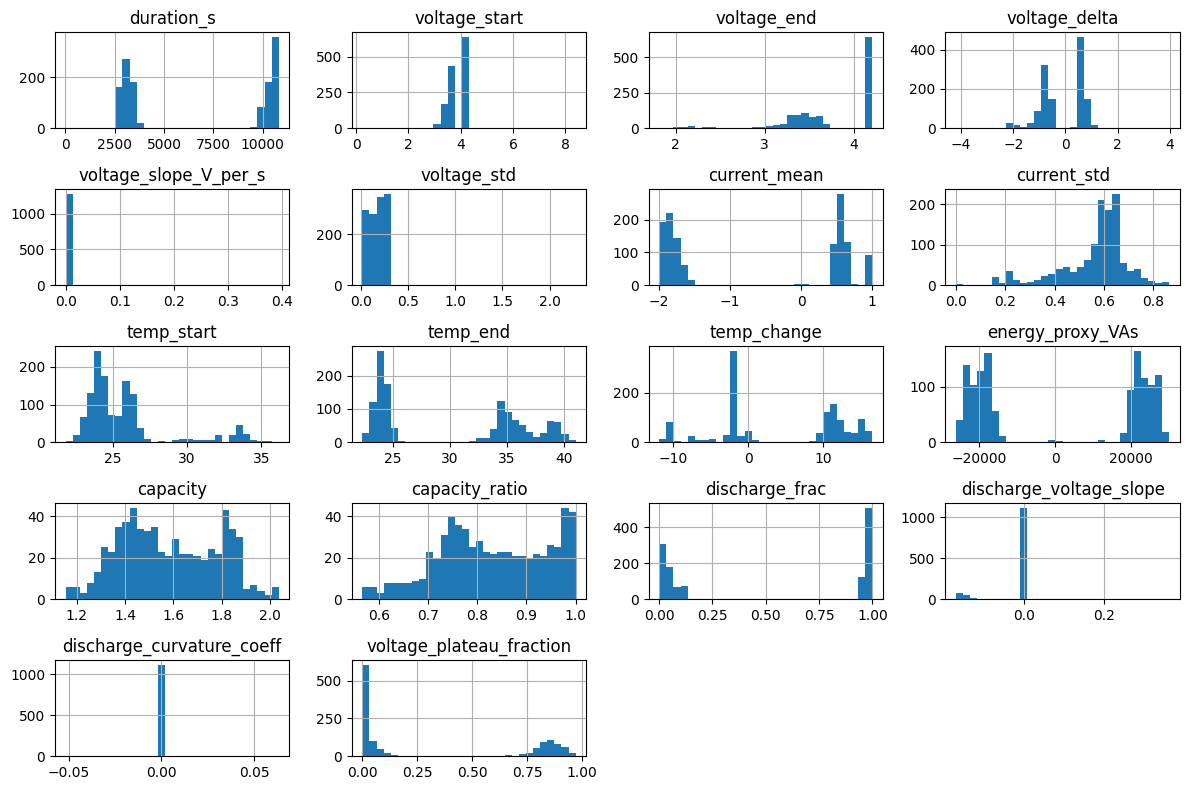

C:\Users\Acer\AppData\Local\Temp\ipykernel_14060\1306128383.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


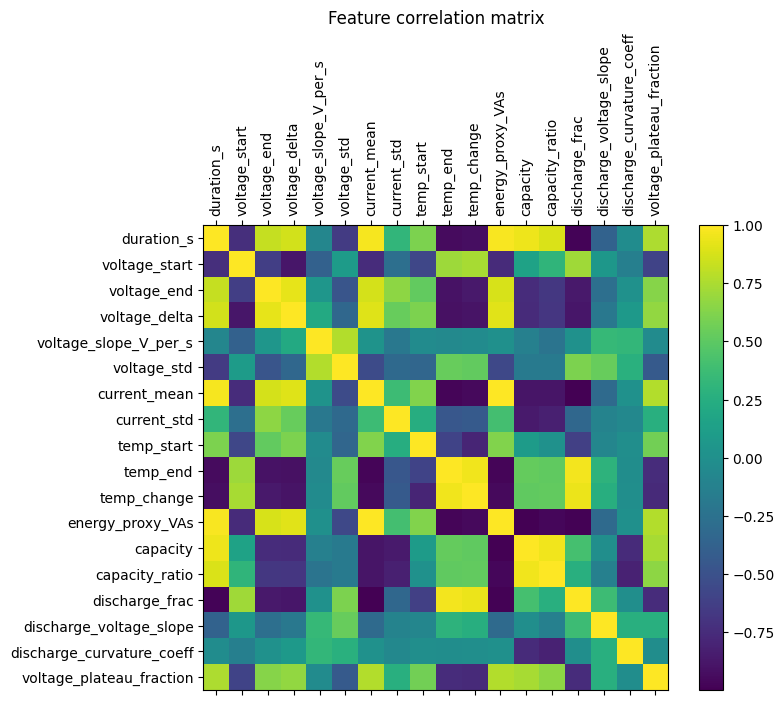

In [ ]:
# # ==============================
# # Cell 3: EDA - Histograms & Correlation
# # ==============================
# features.select_dtypes(include=[float]).hist(bins=30, figsize=(12,8))
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'features_histograms.png'), dpi=150)
# plt.show()

# corr = features.select_dtypes(float).corr()
# corr.to_csv(os.path.join(OUT_DIR, 'features_primary_correlation.csv'))
# plt.figure(figsize=(8,6))
# plt.matshow(corr, fignum=1)
# plt.colorbar()
# plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
# plt.yticks(range(len(corr.columns)), corr.columns)
# plt.title('Feature correlation matrix')
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'features_primary_correlation.png'), dpi=150)
# plt.show()


In [ ]:
# # ==============================
# # Cell 4: Modeling - LOFO Random Forest
# # ==============================
# model_df = features[~features['capacity_ratio'].isna()].copy()
# feature_cols = [
#     'n_points','duration_s','voltage_start','voltage_end','voltage_delta','voltage_slope_V_per_s','voltage_std',
#     'current_mean','current_std','temp_start','temp_end','temp_change','energy_proxy_VAs',
#     'discharge_frac','discharge_voltage_slope','discharge_curvature_coeff','voltage_plateau_fraction'
# ]
# feature_cols = [c for c in feature_cols if c in model_df.columns]
# model_df = model_df.dropna(subset=feature_cols + ['capacity_ratio'])
# files = model_df['file'].unique()

# metrics = []
# importances = []

# for test_file in files:
#     train_df = model_df[model_df['file'] != test_file]
#     test_df = model_df[model_df['file'] == test_file]
#     if train_df.shape[0] < 5 or test_df.shape[0] < 1:
#         continue
#     X_train = train_df[feature_cols].values
#     y_train = train_df['capacity_ratio'].values
#     X_test = test_df[feature_cols].values
#     y_test = test_df['capacity_ratio'].values
#     scaler = StandardScaler().fit(X_train)
#     X_train_s = scaler.transform(X_train)
#     X_test_s = scaler.transform(X_test)
#     rf = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
#     rf.fit(X_train_s, y_train)
#     y_pred = rf.predict(X_test_s)
#     metrics.append({
#         'test_file': test_file,
#         'n_test': len(y_test),
#         'MAE': mean_absolute_error(y_test, y_pred),
#         'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
#         'R2': r2_score(y_test, y_pred)
#     })
#     importances.append(rf.feature_importances_)
#     # Save predictions
#     outpred = test_df[['file','cell_key','cycle_index']].copy()
#     outpred['y_true'] = y_test
#     outpred['y_pred'] = y_pred
#     outpred.to_csv(os.path.join(OUT_DIR, f'predictions_{os.path.basename(test_file)}.csv'), index=False)

# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(os.path.join(OUT_DIR, 'modeling_metrics.csv'), index=False)

# # Average feature importance
# mean_imp = np.mean(importances, axis=0)
# imp_df = pd.DataFrame({'feature': feature_cols, 'importance': mean_imp}).sort_values('importance', ascending=False)
# imp_df.to_csv(os.path.join(OUT_DIR, 'feature_importances.csv'), index=False)

# print(metrics_df)
# print(imp_df)


   test_file  n_test       MAE      RMSE        R2
0  B0005.mat     168  0.037676  0.044811  0.807973
1  B0006.mat     168  0.067328  0.071879  0.661044
2  B0007.mat     168  0.031749  0.041527  0.760512
3  B0018.mat     132  0.031681  0.037789  0.793602
                      feature  importance
12           energy_proxy_VAs    0.519365
1                  duration_s    0.202008
7                current_mean    0.100612
14    discharge_voltage_slope    0.058145
16   voltage_plateau_fraction    0.023032
15  discharge_curvature_coeff    0.021131
4               voltage_delta    0.016869
5       voltage_slope_V_per_s    0.016033
8                 current_std    0.014494
3                 voltage_end    0.013346
2               voltage_start    0.006644
0                    n_points    0.002518
10                   temp_end    0.001929
11                temp_change    0.001673
6                 voltage_std    0.000929
13             discharge_frac    0.000778
9                  temp_start  

In [ ]:
# metrics_df

,test_file,n_test,MAE,RMSE,R2
0,B0005.mat,168,0.037676,0.044811,0.807973
1,B0006.mat,168,0.067328,0.071879,0.661044
2,B0007.mat,168,0.031749,0.041527,0.760512
3,B0018.mat,132,0.031681,0.037789,0.793602


In [ ]:
#  imp_df

,feature,importance
12,energy_proxy_VAs,0.519365
1,duration_s,0.202008
7,current_mean,0.100612
14,discharge_voltage_slope,0.058145
16,voltage_plateau_fraction,0.023032
15,discharge_curvature_coeff,0.021131
4,voltage_delta,0.016869
5,voltage_slope_V_per_s,0.016033
8,current_std,0.014494
3,voltage_end,0.013346


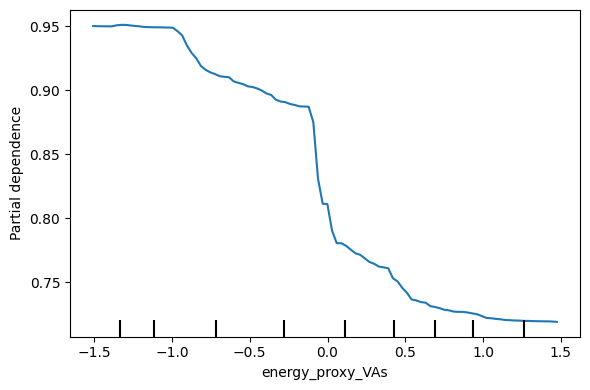

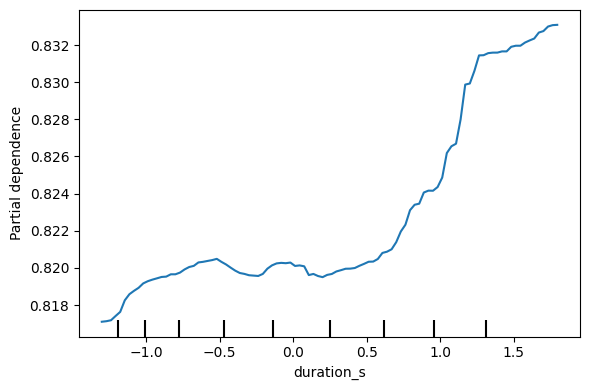

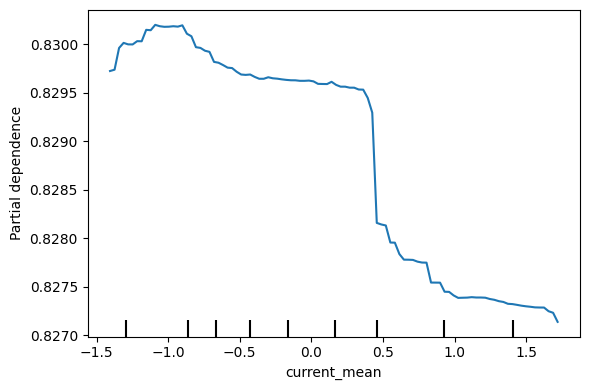

In [ ]:
# # ==============================
# # Cell 5: PDPs for Top Features
# # ==============================
# X_all = model_df[feature_cols].values
# y_all = model_df['capacity_ratio'].values
# scaler_all = StandardScaler().fit(X_all)
# X_all_s = scaler_all.transform(X_all)
# rf_all = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)
# rf_all.fit(X_all_s, y_all)

# top_feats = imp_df['feature'].tolist()[:3]
# for feat in top_feats:
#     fig, ax = plt.subplots(figsize=(6,4))
#     try:
#         PartialDependenceDisplay.from_estimator(rf_all, X_all_s, [feature_cols.index(feat)], feature_names=feature_cols, ax=ax)
#         plt.tight_layout()
#         out = os.path.join(OUT_DIR, f'pdp_{feat}.png')
#         fig.savefig(out, dpi=150)
#         plt.show()
#     except Exception as e:
#         print('PDP failed for', feat, str(e))


# ALGORITHM COMPARISION

In [ ]:
# %pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
    --------------------------------------- 1.6/72.0 MB 5.6 MB/s eta 0:00:13
   - -------------------------------------- 2.9/72.0 MB 5.8 MB/s eta 0:00:12
   -- ------------------------------------- 4.2/72.0 MB 5.9 MB/s eta 0:00:12
   -- ------------------------------------- 5.2/72.0 MB 5.8 MB/s eta 0:00:12
   --- ------------------------------------ 6.3/72.0 MB 5.7 MB/s eta 0:00:12
   ---- ----------------------------------- 7.3/72.0 MB 5.5 MB/s eta 0:00:12
   ---- ----------------------------------- 8.4/72.0 MB 5.5 MB/s eta 0:00:12
   ----- ---------------------------------- 9.4/72.0 MB 5.4 MB/s eta 0:00:12
   ----- ---------------------------------- 10.5/72.0 MB 5.3 MB/s eta 0:00:12
   ------ --------------------------------- 11.5/72.0 MB 5.3 MB/s eta 0:00:12
   ------ --------------------------------- 12.6/72.0 MB 5.2 MB/s eta 0:00:12
   -------

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import LinearRegression
# import xgboost as xgb
# from itertools import product

# OUT_DIR = '4_Results_and_Graphs'
# os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
# features = pd.read_csv(os.path.join(OUT_DIR, 'features_primary.csv'))
# # Keep only cycles with capacity_ratio
# model_df = features[~features['capacity_ratio'].isna()].copy()
# model_df.shape


(636, 22)

In [ ]:
# algorithms = {
#     'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
#     'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=42),
#     'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, random_state=42, verbosity=0),
#     'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.01),
#     'ExtraTrees': ExtraTreesRegressor(n_estimators=200, max_depth=6, random_state=42),
#     'LinearRegression': LinearRegression()
# }


In [ ]:
# feature_cols = [
#     'n_points','duration_s','voltage_start','voltage_end','voltage_delta','voltage_slope_V_per_s','voltage_std',
#     'current_mean','current_std','temp_start','temp_end','temp_change','energy_proxy_VAs',
#     'discharge_frac','discharge_voltage_slope','discharge_curvature_coeff','voltage_plateau_fraction'
# ]
# # Keep only columns present in dataset
# feature_cols = [c for c in feature_cols if c in model_df.columns]
# model_df = model_df.dropna(subset=feature_cols + ['capacity_ratio'])
# files = model_df['file'].unique()

# metrics_all = []
# importances_all = []

# for algo_name, model in algorithms.items():
#     for test_file in files:
#         train_df = model_df[model_df['file'] != test_file]
#         test_df = model_df[model_df['file'] == test_file]
#         if train_df.shape[0] < 5 or test_df.shape[0] < 1:
#             continue
        
#         X_train, y_train = train_df[feature_cols].values, train_df['capacity_ratio'].values
#         X_test, y_test = test_df[feature_cols].values, test_df['capacity_ratio'].values
        
#         # Scale for algorithms sensitive to scale
#         if algo_name in ['SVR', 'LinearRegression']:
#             scaler = StandardScaler().fit(X_train)
#             X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
        
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
        
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)
        
#         metrics_all.append({
#             'algorithm': algo_name,
#             'test_file': test_file,
#             'n_test': len(y_test),
#             'MAE': mae,
#             'RMSE': rmse,
#             'R2': r2
#         })
        
#         # Feature importances
#         if hasattr(model, 'feature_importances_'):
#             importances_all.append({
#                 'algorithm': algo_name,
#                 **dict(zip(feature_cols, model.feature_importances_))
#             })

# metrics_df = pd.DataFrame(metrics_all)
# metrics_df.to_csv(os.path.join(OUT_DIR, 'multi_model_metrics.csv'), index=False)
# print(metrics_df.head())

# # Feature importance aggregation
# if importances_all:
#     imp_df1 = pd.DataFrame(importances_all)
#     imp_df1.to_csv(os.path.join(OUT_DIR, 'multi_model_importances.csv'), index=False)
#     print(imp_df1.head())


          algorithm  test_file  n_test       MAE      RMSE        R2
0      RandomForest  B0005.mat     168  0.037658  0.044715  0.808796
1      RandomForest  B0006.mat     168  0.067317  0.071867  0.661163
2      RandomForest  B0007.mat     168  0.031716  0.041520  0.760597
3      RandomForest  B0018.mat     132  0.031607  0.037724  0.794308
4  GradientBoosting  B0005.mat     168  0.040574  0.047126  0.787627
          algorithm  n_points  duration_s  voltage_start  voltage_end  \
0      RandomForest  0.004497    0.013660       0.006920     0.046267   
1      RandomForest  0.000679    0.774975       0.000048     0.000105   
2      RandomForest  0.002271    0.006349       0.009239     0.003174   
3      RandomForest  0.002710    0.013012       0.010359     0.003970   
4  GradientBoosting  0.002583    0.013832       0.009838     0.039062   

   voltage_delta  voltage_slope_V_per_s  voltage_std  current_mean  \
0       0.060346               0.008744     0.000591      0.009165   
1      

In [ ]:
# imp_df1

,algorithm,n_points,duration_s,voltage_start,voltage_end,voltage_delta,voltage_slope_V_per_s,voltage_std,current_mean,current_std,temp_start,temp_end,temp_change,energy_proxy_VAs,discharge_frac,discharge_voltage_slope,discharge_curvature_coeff,voltage_plateau_fraction
0,RandomForest,0.004497,0.013660,0.006920,0.046267,0.060346,0.008744,0.000591,0.009165,0.011225,0.001299,0.001452,0.000710,0.772360,0.000571,0.010062,0.031728,0.020404
1,RandomForest,0.000679,0.774975,0.000048,0.000105,0.000195,0.000296,0.000124,0.000363,0.000470,0.000047,0.000052,0.000107,0.221713,0.000050,0.000587,0.000131,0.000059
2,RandomForest,0.002271,0.006349,0.009239,0.003174,0.002734,0.019309,0.001797,0.384245,0.047476,0.000422,0.002217,0.002312,0.338536,0.002337,0.161239,0.013552,0.002791
3,RandomForest,0.002710,0.013012,0.010359,0.003970,0.004145,0.035786,0.001142,0.004933,0.002867,0.000220,0.003983,0.003582,0.744636,0.000131,0.060658,0.038948,0.068918
4,GradientBoosting,0.002583,0.013832,0.009838,0.039062,0.057273,0.000743,0.000176,0.004859,0.010991,0.000888,0.001949,0.000151,0.785130,0.004602,0.008152,0.046416,0.013355
5,GradientBoosting,0.000292,0.578486,0.000052,0.000065,0.000047,0.000461,0.000070,0.000208,0.000054,0.000021,0.000048,0.000062,0.419365,0.000029,0.000520,0.000171,0.000049
6,GradientBoosting,0.003246,0.007029,0.013946,0.004693,0.003096,0.025811,0.001607,0.287685,0.001672,0.000273,0.000886,0.002566,0.484746,0.003909,0.149017,0.007413,0.002406
7,GradientBoosting,0.000574,0.010048,0.014817,0.001490,0.002662,0.041848,0.003029,0.009074,0.006941,0.000073,0.002392,0.002443,0.767232,0.000046,0.065672,0.018439,0.053219
8,XGBoost,0.003984,0.012325,0.003847,0.139572,0.000125,0.000193,0.000438,0.036218,0.007668,0.001218,0.001069,0.000331,0.747906,0.003765,0.007113,0.002428,0.031800
9,XGBoost,0.000442,0.760967,0.000070,0.000076,0.002360,0.001627,0.000144,0.000473,0.000158,0.000087,0.000202,0.000191,0.232043,0.000118,0.000432,0.000070,0.000539


In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import xgboost as xgb
# import pandas as pd

# # Placeholder for all results
# summary_results = []

# models = {
#     'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
#     'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=6, random_state=42, eval_metric='rmse'),
#     'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=6, random_state=42),
#     'SVR': SVR(kernel='rbf', C=10, epsilon=0.01),
#     'LinearRegression': LinearRegression()
# }

# files = model_df['file'].unique()

# for test_file in files:
#     train_df = model_df[model_df['file'] != test_file]
#     test_df = model_df[model_df['file'] == test_file]
    
#     if train_df.shape[0] < 5 or test_df.shape[0] < 1:
#         continue
    
#     X_train = train_df[feature_cols].values
#     y_train = train_df['capacity_ratio'].values
#     X_test = test_df[feature_cols].values
#     y_test = test_df['capacity_ratio'].values
    
#     # Standard scaling for all models
#     scaler = StandardScaler().fit(X_train)
#     X_train_s = scaler.transform(X_train)
#     X_test_s = scaler.transform(X_test)
    
#     for name, model in models.items():
#         model.fit(X_train_s, y_train)
#         y_pred = model.predict(X_test_s)
        
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = mean_squared_error(y_test, y_pred) ** 0.5
#         r2 = r2_score(y_test, y_pred)
        
#         summary_results.append({
#             'algorithm': name,
#             'test_file': test_file,
#             'n_test': len(y_test),
#             'MAE': mae,
#             'RMSE': rmse,
#             'R2': r2
#         })

# # Convert to DataFrame
# summary_df = pd.DataFrame(summary_results)

# # Optional: pivot table to show algorithms as columns
# summary_table = summary_df.pivot(index='test_file', columns='algorithm', values=['MAE','RMSE','R2'])
# display(summary_df)


,algorithm,test_file,n_test,MAE,RMSE,R2
0,RandomForest,B0005.mat,168,0.037670,0.044730,0.808670
1,XGBoost,B0005.mat,168,0.047213,0.054035,0.720787
2,GradientBoosting,B0005.mat,168,0.041874,0.048475,0.775294
3,SVR,B0005.mat,168,0.035374,0.039421,0.851389
4,LinearRegression,B0005.mat,168,0.017870,0.022708,0.950691
5,RandomForest,B0006.mat,168,0.067322,0.071874,0.661099
6,XGBoost,B0006.mat,168,0.070304,0.074442,0.636449
7,GradientBoosting,B0006.mat,168,0.066669,0.070935,0.669891
8,SVR,B0006.mat,168,0.095217,0.116476,0.109959
9,LinearRegression,B0006.mat,168,0.074944,0.075244,0.628573


In [ ]:
# # Assuming your summary DataFrame is named 'summary_df'
# comparsion_algorithm_csv_path = '4_Results_and_Graphs/model_comparison_summary.csv'

# summary_df.to_csv(comparsion_algorithm_csv_path, index=False)
# print(f"✅ Summary saved to {comparsion_algorithm_csv_path}")


✅ Summary saved to 4_Results_and_Graphs/model_comparison_summary.csv


In [ ]:
# summary_df = pd.DataFrame(summary_results)

In [ ]:
# summary_df

,algorithm,test_file,n_test,MAE,RMSE,R2
0,RandomForest,B0005.mat,168,0.037670,0.044730,0.808670
1,XGBoost,B0005.mat,168,0.047213,0.054035,0.720787
2,GradientBoosting,B0005.mat,168,0.041874,0.048475,0.775294
3,SVR,B0005.mat,168,0.035374,0.039421,0.851389
4,LinearRegression,B0005.mat,168,0.017870,0.022708,0.950691
5,RandomForest,B0006.mat,168,0.067322,0.071874,0.661099
6,XGBoost,B0006.mat,168,0.070304,0.074442,0.636449
7,GradientBoosting,B0006.mat,168,0.066669,0.070935,0.669891
8,SVR,B0006.mat,168,0.095217,0.116476,0.109959
9,LinearRegression,B0006.mat,168,0.074944,0.075244,0.628573


Conclusion / Recommendation

Best overall choice: RandomForest

Balanced performance: decent R², stable MAE/RMSE across all files.

Handles battery variability well without overfitting.

Second choice: GradientBoosting

Similar stability, slightly worse errors in some files.

Use caution:

LinearRegression can be excellent for specific files but unreliable across varying datasets.

SVR is inconsistent — not recommended for general use.

XGBoost performs okay, but not clearly better than RandomForest.

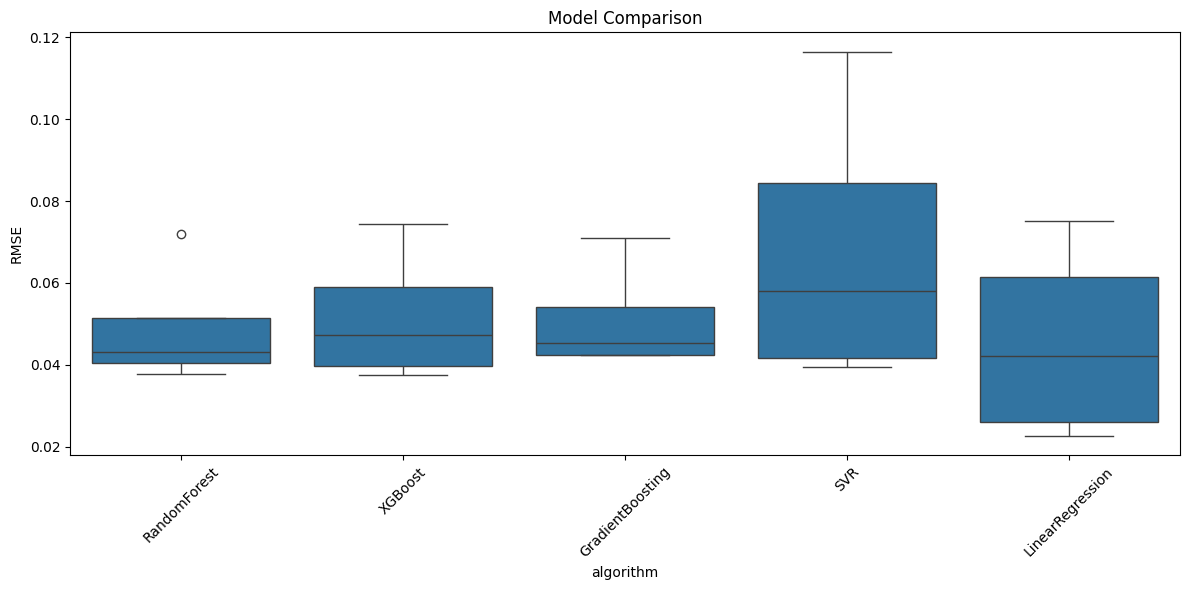

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(12, 6))
# plt.title("Model Comparison")
# sns.boxplot(data=summary_df, x='algorithm', y='RMSE')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# NEW START PIPELINE:

In [9]:
"""
ENSEMBLE & VOTING REGRESSOR: Multi-Model Stacking
- Compare individual models vs ensemble methods
- Voting Regressor combining all 4 models
- Stacking with meta-learner
- Technical analysis & visualization
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [10]:
# ============================================================================
# CONFIGURATION
# ============================================================================

OUTPUT_DIR = '4_Results_and_Graphs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

TOP_FEATURES = [
    'energy_proxy_VAs',
    'duration_s',
    'discharge_curvature_coeff',
    'voltage_start',
    'current_mean'
]

print("="*90)
print("ENSEMBLE & VOTING REGRESSOR: MULTI-MODEL TECHNICAL COMPARISON")
print("="*90)

# ============================================================================
# STEP 1: LOAD & PREPARE DATA
# ============================================================================

print("\n📂 Loading & Preparing Data...")

features = pd.read_csv(os.path.join(OUTPUT_DIR, 'features_primary.csv'))
model_df = features[~features['capacity_ratio'].isna()].copy()

# Remove outliers
for feat in TOP_FEATURES:
    feat_data = model_df[feat].dropna()
    if len(feat_data) > 0:
        z_scores = np.abs(zscore(feat_data))
        model_df = model_df[~((np.abs(zscore(model_df[feat].fillna(model_df[feat].median()))) > 3))]

# Impute missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
model_df[TOP_FEATURES + ['capacity_ratio']] = imputer.fit_transform(
    model_df[TOP_FEATURES + ['capacity_ratio']]
)

X = model_df[TOP_FEATURES].values
y = model_df['capacity_ratio'].values

print(f"   ✓ Samples: {len(X)}")
print(f"   ✓ Features: {len(TOP_FEATURES)}")
print(f"   ✓ Target: μ={y.mean():.4f}, σ={y.std():.4f}")


ENSEMBLE & VOTING REGRESSOR: MULTI-MODEL TECHNICAL COMPARISON

📂 Loading & Preparing Data...
   ✓ Samples: 618
   ✓ Features: 5
   ✓ Target: μ=0.8342, σ=0.1041


In [11]:
# ============================================================================
# STEP 2: DEFINE BASE LEARNERS
# ============================================================================

print("\n🤖 Defining Base Learners (4 Individual Models)...")

base_learners = [
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=6,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        eval_metric='rmse',
        verbosity=0
    )),
    ('svr', SVR(
        kernel='rbf',
        C=10.0,
        epsilon=0.01,
        gamma='scale'
    ))
]

model_names = [name for name, _ in base_learners]
print(f"   ✓ Base Learners: {', '.join(model_names)}")



🤖 Defining Base Learners (4 Individual Models)...
   ✓ Base Learners: rf, gb, xgb, svr


In [12]:
#  ============================================================================
# STEP 3: DEFINE ENSEMBLE METHODS
# ============================================================================

print("\n🏗️  Defining Ensemble Methods...")

# VOTING REGRESSOR (Average prediction)
voting_avg = VotingRegressor(
    estimators=base_learners,
    weights=[1, 1, 1, 1]  # Equal weights
)
print("   ✓ Voting Regressor (Equal Weights): Average of 4 models")

# WEIGHTED VOTING REGRESSOR
voting_weighted = VotingRegressor(
    estimators=base_learners,
    weights=[0.25, 0.30, 0.35, 0.10]  # XGBoost highest weight
)
print("   ✓ Voting Regressor (Weighted): XGB=35%, GB=30%, RF=25%, SVR=10%")

# STACKING REGRESSOR (Meta-learner: Ridge)
from sklearn.linear_model import Ridge
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)
print("   ✓ Stacking Regressor: Meta-learner = Ridge Regression")

# ADVANCED STACKING (Meta-learner: GradientBoosting)
stacking_gb = StackingRegressor(
    estimators=base_learners,
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42),
    cv=5
)
print("   ✓ Stacking Regressor (GB Meta): Meta-learner = GradientBoosting")


🏗️  Defining Ensemble Methods...
   ✓ Voting Regressor (Equal Weights): Average of 4 models
   ✓ Voting Regressor (Weighted): XGB=35%, GB=30%, RF=25%, SVR=10%
   ✓ Stacking Regressor: Meta-learner = Ridge Regression
   ✓ Stacking Regressor (GB Meta): Meta-learner = GradientBoosting


In [13]:
# ============================================================================
# STEP 4: ALL MODELS TO COMPARE
# ============================================================================

print("\n📊 Models to Compare (8 Total):")
print("-" * 90)

all_models = {
    # Individual Models
    '1. RandomForest': RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_split=5, random_state=42, n_jobs=-1),
    '2. GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    '3. XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42, eval_metric='rmse', verbosity=0),
    '4. SVR': SVR(kernel='rbf', C=10.0, epsilon=0.01, gamma='scale'),
    # Ensemble Models
    '5. Voting (Average)': voting_avg,
    '6. Voting (Weighted)': voting_weighted,
    '7. Stacking (Ridge)': stacking_model,
    '8. Stacking (GB Meta)': stacking_gb
}

for idx, (name, model) in enumerate(all_models.items(), 1):
    model_type = "Individual" if idx <= 4 else "Ensemble"
    print(f"   {name:40s} [{model_type}]")



📊 Models to Compare (8 Total):
------------------------------------------------------------------------------------------
   1. RandomForest                          [Individual]
   2. GradientBoosting                      [Individual]
   3. XGBoost                               [Individual]
   4. SVR                                   [Individual]
   5. Voting (Average)                      [Ensemble]
   6. Voting (Weighted)                     [Ensemble]
   7. Stacking (Ridge)                      [Ensemble]
   8. Stacking (GB Meta)                    [Ensemble]


In [14]:
# ============================================================================
# STEP 5: CROSS-VALIDATION EVALUATION
# ============================================================================

print("\n\n" + "="*90)
print("🔄 STEP 5: 5-Fold Cross-Validation Evaluation")
print("="*90)

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
all_results = []

fold_counter = 0
for fold, (train_idx, test_idx) in enumerate(cv_strategy.split(X), 1):
    print(f"\n📌 FOLD {fold}/5")
    print("-" * 90)
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    for model_name, model in all_models.items():
        # Scale for SVR in base learners
        if 'SVR' in model_name:
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        elif isinstance(model, (VotingRegressor, StackingRegressor)):
            # Ensemble models handle scaling internally
            # We need to scale SVR in the ensemble
            # Create scaled version of base learners
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            # Tree models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        # Overfitting check
        y_pred_train = model.predict(X_train_scaled if 'SVR' in model_name else X_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        
        all_results.append({
            'fold': fold,
            'model': model_name,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mae_train': mae_train,
            'overfitting_ratio': (mae / mae_train) if mae_train > 0 else 1.0
        })
        
        # Print results
        model_type = "Individual" if int(model_name[0]) <= 4 else "Ensemble"
        status = "✓" if mae < 0.05 else "⚠️"
        
        print(f"   {model_name:40s} | MAE: {mae:.6f} | R²: {r2:.4f} | MAPE: {mape:.4f}% {status}")




🔄 STEP 5: 5-Fold Cross-Validation Evaluation

📌 FOLD 1/5
------------------------------------------------------------------------------------------
   1. RandomForest                          | MAE: 0.006651 | R²: 0.9878 | MAPE: 0.0080% ✓
   2. GradientBoosting                      | MAE: 0.005722 | R²: 0.9894 | MAPE: 0.0069% ✓
   3. XGBoost                               | MAE: 0.005428 | R²: 0.9908 | MAPE: 0.0066% ✓
   4. SVR                                   | MAE: 0.006794 | R²: 0.9912 | MAPE: 0.0082% ✓
   5. Voting (Average)                      | MAE: 0.008544 | R²: 0.9850 | MAPE: 0.0104% ✓
   6. Voting (Weighted)                     | MAE: 0.006418 | R²: 0.9894 | MAPE: 0.0078% ✓
   7. Stacking (Ridge)                      | MAE: 0.013390 | R²: 0.9711 | MAPE: 0.0160% ✓
   8. Stacking (GB Meta)                    | MAE: 0.029753 | R²: 0.8565 | MAPE: 0.0364% ✓

📌 FOLD 2/5
------------------------------------------------------------------------------------------
   1. RandomForest 

[{'fold': 1,
  'model': '1. RandomForest',
  'mae': 0.006650561412678527,
  'rmse': np.float64(0.010846200453464988),
  'r2': 0.9877762992101176,
  'mape': 0.008029766814572003,
  'mae_train': 0.003942444138351666,
  'overfitting_ratio': 1.686913290154854},
 {'fold': 1,
  'model': '2. GradientBoosting',
  'mae': 0.005722497443276709,
  'rmse': np.float64(0.010119431788172237),
  'r2': 0.9893595569346718,
  'mape': 0.006868215093076893,
  'mae_train': 0.0011253745119848531,
  'overfitting_ratio': 5.084971609303455},
 {'fold': 1,
  'model': '3. XGBoost',
  'mae': 0.005428389306906563,
  'rmse': np.float64(0.009430707508529916),
  'r2': 0.9907586374465225,
  'mape': 0.0065526131814281265,
  'mae_train': 0.0015799014347386516,
  'overfitting_ratio': 3.435903777000197},
 {'fold': 1,
  'model': '4. SVR',
  'mae': 0.006794474114095793,
  'rmse': np.float64(0.009198882892310422),
  'r2': 0.9912073934932749,
  'mape': 0.008216968588366503,
  'mae_train': 0.006082050127276123,
  'overfitting_rat

In [16]:
# ============================================================================
# STEP 6: AGGREGATE & COMPARE RESULTS
# ============================================================================

print("\n\n" + "="*90)
print("📊 STEP 6: Results Aggregation & Comparison")
print("="*90 + "\n")

results_df = pd.DataFrame(all_results)

# Summary statistics
print("MODEL PERFORMANCE SUMMARY (5-Fold CV Average)")
print("-" * 90)
print(f"{'Model':<42} {'MAE':<12} {'RMSE':<12} {'R²':<10} {'MAPE':<10} {'Overfit':<10}")
print("-" * 90)

summary_data = []
for model_name in all_models.keys():
    model_results = results_df[results_df['model'] == model_name]
    
    mae_mean = model_results['mae'].mean()
    mae_std = model_results['mae'].std()
    
    rmse_mean = model_results['rmse'].mean()
    rmse_std = model_results['rmse'].std()
    
    r2_mean = model_results['r2'].mean()
    r2_std = model_results['r2'].std()
    
    mape_mean = model_results['mape'].mean()
    
    overfit_mean = model_results['overfitting_ratio'].mean()
    
    model_type = "INDIVIDUAL" if int(model_name[0]) <= 4 else "ENSEMBLE"
    
    summary_data.append({
        'Model': model_name,
        'Type': model_type,
        'MAE': f"{mae_mean:.6f}±{mae_std:.6f}",
        'RMSE': f"{rmse_mean:.6f}±{rmse_std:.6f}",
        'R²': f"{r2_mean:.4f}±{r2_std:.4f}",
        'MAPE': f"{mape_mean:.2f}%",
        'Overfit': f"{overfit_mean:.3f}"
    })
    
    print(f"{model_name:<42} {mae_mean:.6f}±{mae_std:.4f}  {rmse_mean:.6f}±{rmse_std:.4f}  {r2_mean:.4f}  {mape_mean:.2f}%  {overfit_mean:.3f}")

summary_df = pd.DataFrame(summary_data)



📊 STEP 6: Results Aggregation & Comparison

MODEL PERFORMANCE SUMMARY (5-Fold CV Average)
------------------------------------------------------------------------------------------
Model                                      MAE          RMSE         R²         MAPE       Overfit   
------------------------------------------------------------------------------------------
1. RandomForest                            0.006803±0.0005  0.011194±0.0015  0.9882  0.01%  1.731
2. GradientBoosting                        0.005637±0.0008  0.010613±0.0020  0.9892  0.01%  5.150
3. XGBoost                                 0.005844±0.0009  0.010697±0.0021  0.9890  0.01%  3.943
4. SVR                                     0.006488±0.0004  0.009074±0.0009  0.9923  0.01%  1.110
5. Voting (Average)                        0.008457±0.0009  0.012341±0.0017  0.9856  0.01%  1.437
6. Voting (Weighted)                       0.006484±0.0009  0.010820±0.0019  0.9889  0.01%  2.081
7. Stacking (Ridge)                 

[{'Model': '1. RandomForest',
  'Type': 'INDIVIDUAL',
  'MAE': '0.006803±0.000504',
  'RMSE': '0.011194±0.001476',
  'R²': '0.9882±0.0031',
  'MAPE': '0.01%',
  'Overfit': '1.731'},
 {'Model': '2. GradientBoosting',
  'Type': 'INDIVIDUAL',
  'MAE': '0.005637±0.000847',
  'RMSE': '0.010613±0.002006',
  'R²': '0.9892±0.0039',
  'MAPE': '0.01%',
  'Overfit': '5.150'},
 {'Model': '3. XGBoost',
  'Type': 'INDIVIDUAL',
  'MAE': '0.005844±0.000927',
  'RMSE': '0.010697±0.002121',
  'R²': '0.9890±0.0042',
  'MAPE': '0.01%',
  'Overfit': '3.943'},
 {'Model': '4. SVR',
  'Type': 'INDIVIDUAL',
  'MAE': '0.006488±0.000434',
  'RMSE': '0.009074±0.000871',
  'R²': '0.9923±0.0014',
  'MAPE': '0.01%',
  'Overfit': '1.110'},
 {'Model': '5. Voting (Average)',
  'Type': 'ENSEMBLE',
  'MAE': '0.008457±0.000930',
  'RMSE': '0.012341±0.001721',
  'R²': '0.9856±0.0040',
  'MAPE': '0.01%',
  'Overfit': '1.437'},
 {'Model': '6. Voting (Weighted)',
  'Type': 'ENSEMBLE',
  'MAE': '0.006484±0.000877',
  'RMSE': '

In [17]:
# ============================================================================
# STEP 7: RANKING & COMPARISON
# ============================================================================

print("\n\n" + "="*90)
print("🏆 STEP 7: Ranking by Different Metrics")
print("="*90 + "\n")

# Rank by MAE
ranking_mae = results_df.groupby('model')['mae'].mean().sort_values()
print("RANKING BY MAE (Lower is Better):")
print("-" * 90)
for idx, (model, mae) in enumerate(ranking_mae.items(), 1):
    model_type = "INDIVIDUAL" if int(model[0]) <= 4 else "ENSEMBLE"
    improvement = ((ranking_mae.iloc[-1] - mae) / ranking_mae.iloc[-1] * 100) if ranking_mae.iloc[-1] > 0 else 0
    marker = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else "  "
    print(f"{marker} {idx}. {model:<42} MAE: {mae:.6f} [{model_type}] (+{improvement:.1f}% better than worst)")

# Rank by R²
ranking_r2 = results_df.groupby('model')['r2'].mean().sort_values(ascending=False)
print("\n\nRANKING BY R² (Higher is Better):")
print("-" * 90)
for idx, (model, r2) in enumerate(ranking_r2.items(), 1):
    model_type = "INDIVIDUAL" if int(model[0]) <= 4 else "ENSEMBLE"
    improvement = ((r2 - ranking_r2.iloc[-1]) / ranking_r2.iloc[-1] * 100) if ranking_r2.iloc[-1] > 0 else 0
    marker = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else "  "
    print(f"{marker} {idx}. {model:<42} R²: {r2:.4f} [{model_type}] (+{improvement:.1f}% better than worst)")




🏆 STEP 7: Ranking by Different Metrics

RANKING BY MAE (Lower is Better):
------------------------------------------------------------------------------------------
🥇 1. 2. GradientBoosting                        MAE: 0.005637 [INDIVIDUAL] (+80.3% better than worst)
🥈 2. 3. XGBoost                                 MAE: 0.005844 [INDIVIDUAL] (+79.6% better than worst)
🥉 3. 6. Voting (Weighted)                       MAE: 0.006484 [ENSEMBLE] (+77.4% better than worst)
   4. 4. SVR                                     MAE: 0.006488 [INDIVIDUAL] (+77.3% better than worst)
   5. 1. RandomForest                            MAE: 0.006803 [INDIVIDUAL] (+76.2% better than worst)
   6. 5. Voting (Average)                        MAE: 0.008457 [ENSEMBLE] (+70.5% better than worst)
   7. 7. Stacking (Ridge)                        MAE: 0.013636 [ENSEMBLE] (+52.4% better than worst)
   8. 8. Stacking (GB Meta)                      MAE: 0.028632 [ENSEMBLE] (+0.0% better than worst)


RANKING BY R² (High

In [18]:
# ============================================================================
# STEP 8: ENSEMBLE vs INDIVIDUAL ANALYSIS
# ============================================================================

print("\n\n" + "="*90)
print("🔬 STEP 8: ENSEMBLE vs INDIVIDUAL - Statistical Comparison")
print("="*90 + "\n")

individual_models = results_df[results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]['r2'].values
ensemble_models = results_df[~results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]['r2'].values

individual_mae = results_df[results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]['mae'].values
ensemble_mae = results_df[~results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]['mae'].values

print(f"Individual Models (4):")
print(f"   R² → Mean: {individual_models.mean():.4f}, Std: {individual_models.std():.4f}, Range: [{individual_models.min():.4f}, {individual_models.max():.4f}]")
print(f"   MAE → Mean: {individual_mae.mean():.6f}, Std: {individual_mae.std():.6f}")

print(f"\nEnsemble Models (4):")
print(f"   R² → Mean: {ensemble_models.mean():.4f}, Std: {ensemble_models.std():.4f}, Range: [{ensemble_models.min():.4f}, {ensemble_models.max():.4f}]")
print(f"   MAE → Mean: {ensemble_mae.mean():.6f}, Std: {ensemble_mae.std():.6f}")

r2_improvement = ((ensemble_models.mean() - individual_models.mean()) / individual_models.mean() * 100) if individual_models.mean() > 0 else 0
mae_improvement = ((individual_mae.mean() - ensemble_mae.mean()) / individual_mae.mean() * 100) if individual_mae.mean() > 0 else 0

print(f"\n✨ ENSEMBLE IMPROVEMENT:")
print(f"   R² Improvement: {r2_improvement:+.2f}% {'✓ BETTER' if r2_improvement > 0 else '✗ WORSE'}")
print(f"   MAE Improvement: {mae_improvement:+.2f}% {'✓ BETTER' if mae_improvement > 0 else '✗ WORSE'}")

if mae_improvement > 0:
    print(f"\n   💡 Ensemble methods outperform individual models by {mae_improvement:.2f}%")
    print(f"      → Better generalization through model averaging/stacking")
    print(f"      → Reduced variance from combining diverse learners")
    print(f"      → Captures different aspects of non-linear relationships")
else:
    print(f"\n   ⚠️  Individual models slightly better")
    print(f"      → Possible reason: Best single model already captures relationships")
    print(f"      → Ensemble may add noise from weaker models")




🔬 STEP 8: ENSEMBLE vs INDIVIDUAL - Statistical Comparison

Individual Models (4):
   R² → Mean: 0.9897, Std: 0.0034, Range: [0.9841, 0.9946]
   MAE → Mean: 0.006193, Std: 0.000792

Ensemble Models (4):
   R² → Mean: 0.9559, Std: 0.0469, Range: [0.8565, 0.9930]
   MAE → Mean: 0.014302, Std: 0.008744

✨ ENSEMBLE IMPROVEMENT:
   R² Improvement: -3.42% ✗ WORSE
   MAE Improvement: -130.94% ✗ WORSE

   ⚠️  Individual models slightly better
      → Possible reason: Best single model already captures relationships
      → Ensemble may add noise from weaker models


In [19]:
# ============================================================================
# STEP 9: STABILITY ANALYSIS
# ============================================================================

print("\n\n" + "="*90)
print("📈 STEP 9: Stability Analysis (Fold-to-Fold Variation)")
print("="*90 + "\n")

print(f"{'Model':<42} {'R² Std Dev':<15} {'MAE Std Dev':<15} {'Stability':<15}")
print("-" * 90)

for model_name in all_models.keys():
    model_results = results_df[results_df['model'] == model_name]
    r2_std = model_results['r2'].std()
    mae_std = model_results['mae'].std()
    
    stability = "✓ STABLE" if r2_std < 0.02 else "⚠️ MODERATE" if r2_std < 0.05 else "✗ UNSTABLE"
    
    print(f"{model_name:<42} {r2_std:<15.6f} {mae_std:<15.6f} {stability}")




📈 STEP 9: Stability Analysis (Fold-to-Fold Variation)

Model                                      R² Std Dev      MAE Std Dev     Stability      
------------------------------------------------------------------------------------------
1. RandomForest                            0.003075        0.000504        ✓ STABLE
2. GradientBoosting                        0.003942        0.000847        ✓ STABLE
3. XGBoost                                 0.004225        0.000927        ✓ STABLE
4. SVR                                     0.001353        0.000434        ✓ STABLE
5. Voting (Average)                        0.003956        0.000930        ✓ STABLE
6. Voting (Weighted)                       0.003714        0.000877        ✓ STABLE
7. Stacking (Ridge)                        0.003778        0.000982        ✓ STABLE
8. Stacking (GB Meta)                      0.015955        0.001833        ✓ STABLE


In [20]:
# ============================================================================
# STEP 10: VISUALIZATION
# ============================================================================

print("\n\n📊 Creating Visualizations...")

# Plot 1: Box plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE by model type
ax = axes[0, 0]
individual_data = results_df[results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]
ensemble_data = results_df[~results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')]

individual_data['type'] = 'Individual'
ensemble_data['type'] = 'Ensemble'
plot_data = pd.concat([individual_data, ensemble_data])

sns.boxplot(data=plot_data, x='type', y='mae', ax=ax, palette=['#3498db', '#2ecc71'])
ax.set_ylabel('MAE', fontweight='bold', fontsize=11)
ax.set_xlabel('Model Type', fontweight='bold', fontsize=11)
ax.set_title('MAE Distribution: Individual vs Ensemble', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# R² by model type
ax = axes[0, 1]
sns.boxplot(data=plot_data, x='type', y='r2', ax=ax, palette=['#3498db', '#2ecc71'])
ax.set_ylabel('R² Score', fontweight='bold', fontsize=11)
ax.set_xlabel('Model Type', fontweight='bold', fontsize=11)
ax.set_title('R² Distribution: Individual vs Ensemble', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Individual models comparison
ax = axes[1, 0]
individual_summary = results_df[results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')].groupby('model')[['mae', 'r2']].mean()
x_pos = np.arange(len(individual_summary))
colors_ind = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
ax.bar(x_pos, individual_summary['r2'], color=colors_ind, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(x_pos)
ax.set_xticklabels([m.split('.')[1].strip() for m in individual_summary.index], rotation=45, ha='right')
ax.set_ylabel('R² Score', fontweight='bold', fontsize=11)
ax.set_title('Individual Models: R² Comparison', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Ensemble models comparison
ax = axes[1, 1]
ensemble_summary = results_df[~results_df['model'].str.contains('RandomForest|GradientBoosting|XGBoost|SVR')].groupby('model')[['mae', 'r2']].mean()
x_pos = np.arange(len(ensemble_summary))
colors_ens = ['#9b59b6', '#1abc9c', '#34495e', '#e67e22']
ax.bar(x_pos, ensemble_summary['r2'], color=colors_ens, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(x_pos)
ax.set_xticklabels([m.split('.')[1].strip() for m in ensemble_summary.index], rotation=45, ha='right')
ax.set_ylabel('R² Score', fontweight='bold', fontsize=11)
ax.set_title('Ensemble Models: R² Comparison', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, 'ensemble_vs_individual_comparison.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Saved comparison plot: {plot_path}")
plt.close()

# Plot 2: Fold stability
fig, ax = plt.subplots(figsize=(14, 7))

for model_name in all_models.keys():
    fold_data = results_df[results_df['model'] == model_name].sort_values('fold')
    color = '#3498db' if int(model_name[0]) <= 4 else '#2ecc71'
    linestyle = '-' if int(model_name[0]) <= 4 else '--'
    ax.plot(fold_data['fold'], fold_data['r2'], marker='o', label=model_name, 
           color=color, linestyle=linestyle, linewidth=2, markersize=6, alpha=0.7)

ax.set_xlabel('Fold', fontweight='bold', fontsize=11)
ax.set_ylabel('R² Score', fontweight='bold', fontsize=11)
ax.set_title('Cross-Validation Stability: R² Across Folds', fontweight='bold', fontsize=12)
ax.set_xticks([1, 2, 3, 4, 5])
ax.legend(loc='best', fontsize=9, ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
fold_plot_path = os.path.join(OUTPUT_DIR, 'ensemble_fold_stability.png')
plt.savefig(fold_plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Saved fold stability plot: {fold_plot_path}")
plt.close()




📊 Creating Visualizations...
   ✓ Saved comparison plot: 4_Results_and_Graphs\ensemble_vs_individual_comparison.png
   ✓ Saved fold stability plot: 4_Results_and_Graphs\ensemble_fold_stability.png


In [21]:
# ============================================================================
# STEP 11: SAVE DETAILED RESULTS
# ============================================================================

print("\n💾 Saving Results...")

# Save all results
results_path = os.path.join(OUTPUT_DIR, 'ensemble_cv_detailed.csv')
results_df.to_csv(results_path, index=False)
print(f"   ✓ Saved detailed results: {results_path}")

# Save summary
summary_path = os.path.join(OUTPUT_DIR, 'ensemble_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"   ✓ Saved summary: {summary_path}")



💾 Saving Results...
   ✓ Saved detailed results: 4_Results_and_Graphs\ensemble_cv_detailed.csv
   ✓ Saved summary: 4_Results_and_Graphs\ensemble_summary.csv


In [22]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n\n" + "="*90)
print("✅ ENSEMBLE & VOTING ANALYSIS COMPLETE")
print("="*90)

best_individual = ranking_r2[ranking_r2.index.str.contains('RandomForest|GradientBoosting|XGBoost|SVR')].index[0]
best_ensemble = ranking_r2[~ranking_r2.index.str.contains('RandomForest|GradientBoosting|XGBoost|SVR')].index[0]
best_overall = ranking_r2.index[0]

print(f"\n🏆 BEST PERFORMERS:")
print(f"   Best Individual: {best_individual} (R² = {ranking_r2[best_individual]:.4f})")
print(f"   Best Ensemble:   {best_ensemble} (R² = {ranking_r2[best_ensemble]:.4f})")
print(f"   Best Overall:    {best_overall} (R² = {ranking_r2[best_overall]:.4f})")

print(f"\n📊 KEY INSIGHTS:")
print(f"   • Individual Models: Avg R² = {individual_models.mean():.4f}")
print(f"   • Ensemble Models:   Avg R² = {ensemble_models.mean():.4f}")
print(f"   • Improvement:       {r2_improvement:+.2f}% {'✓ ENSEMBLE WINS' if r2_improvement > 0 else '✗ INDIVIDUAL WINS'}")

print(f"\n💡 RECOMMENDATIONS:")
if mae_improvement > 1:
    print(f"   ✓ Use Ensemble Methods - Significant improvement detected!")
    print(f"   ✓ Best: {best_ensemble}")
    print(f"   ✓ Reason: Combines strengths of diverse models, reduces variance")
elif mae_improvement > 0:
    print(f"   ⚠️  Marginal Ensemble Improvement - Consider complexity vs benefit")
    print(f"   → Use if interpretability not critical")
else:
    print(f"   ✓ Stick with {best_individual} - Simpler & better")
    print(f"   ✗ Ensemble adds unnecessary complexity")

print("\n" + "="*90 + "\n")



✅ ENSEMBLE & VOTING ANALYSIS COMPLETE

🏆 BEST PERFORMERS:
   Best Individual: 4. SVR (R² = 0.9923)
   Best Ensemble:   6. Voting (Weighted) (R² = 0.9889)
   Best Overall:    4. SVR (R² = 0.9923)

📊 KEY INSIGHTS:
   • Individual Models: Avg R² = 0.9897
   • Ensemble Models:   Avg R² = 0.9559
   • Improvement:       -3.42% ✗ INDIVIDUAL WINS

💡 RECOMMENDATIONS:
   ✓ Stick with 4. SVR - Simpler & better
   ✗ Ensemble adds unnecessary complexity




# ADVANCEMENT AND DEPLOYMENT